In [1]:
# Import required libraries and set display configurations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for high-resolution plots in Jupyter
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['axes.unicode_minus'] = False

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Generate synthetic regression dataset
X, y = make_regression(
    n_samples=1000,
    n_features=10,
    n_informative=8,
    n_targets=1,
    noise=0.1,
    random_state=42
)

# Create feature names
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nTarget statistics:")
print(f"Target mean: {df['target'].mean():.2f}")
print(f"Target std: {df['target'].std():.2f}")
print(f"Target min: {df['target'].min():.2f}")
print(f"Target max: {df['target'].max():.2f}")

Dataset shape: (1000, 11)

First 5 rows:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -0.707669   2.122156  -1.260884   0.917862   0.774634  -1.519370   
1   0.668655  -0.730956  -0.535335   0.358454   1.295872   0.685508   
2   0.691619  -0.624510  -1.045529  -0.026261  -0.998212   0.031492   
3   0.146476  -1.167865  -0.111847  -0.452690  -0.800590   1.107721   
4  -2.205566  -0.635362  -1.876553   0.619711   1.274875  -0.624345   

   feature_6  feature_7  feature_8  feature_9      target  
0   1.266911   1.032465  -0.484234   0.443819 -107.660977  
1  -0.175564   0.757922   1.848609   0.098068   82.503167  
2   1.087710   0.746981   0.690074   0.273118   62.844018  
3   0.644311  -0.328375   0.566602   0.523324   80.593656  
4  -0.604745  -1.189667  -0.184525   0.897066 -293.564870  

Target statistics:
Target mean: 1.06
Target std: 108.07
Target min: -328.04
Target max: 313.48


In [3]:
# Data preprocessing pipeline
def preprocess_data(df):
    """
    Preprocess the dataset: separate features and target
    """
    # Separate features and target
    X = df.drop('target', axis=1)
    y = df['target']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(df)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target statistics:")
print(f"Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print("Test target statistics:")
print(f"Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

Training set shape: (800, 10)
Test set shape: (200, 10)
Training target statistics:
Mean: 0.89, Std: 107.17
Test target statistics:
Mean: 1.75, Std: 111.87


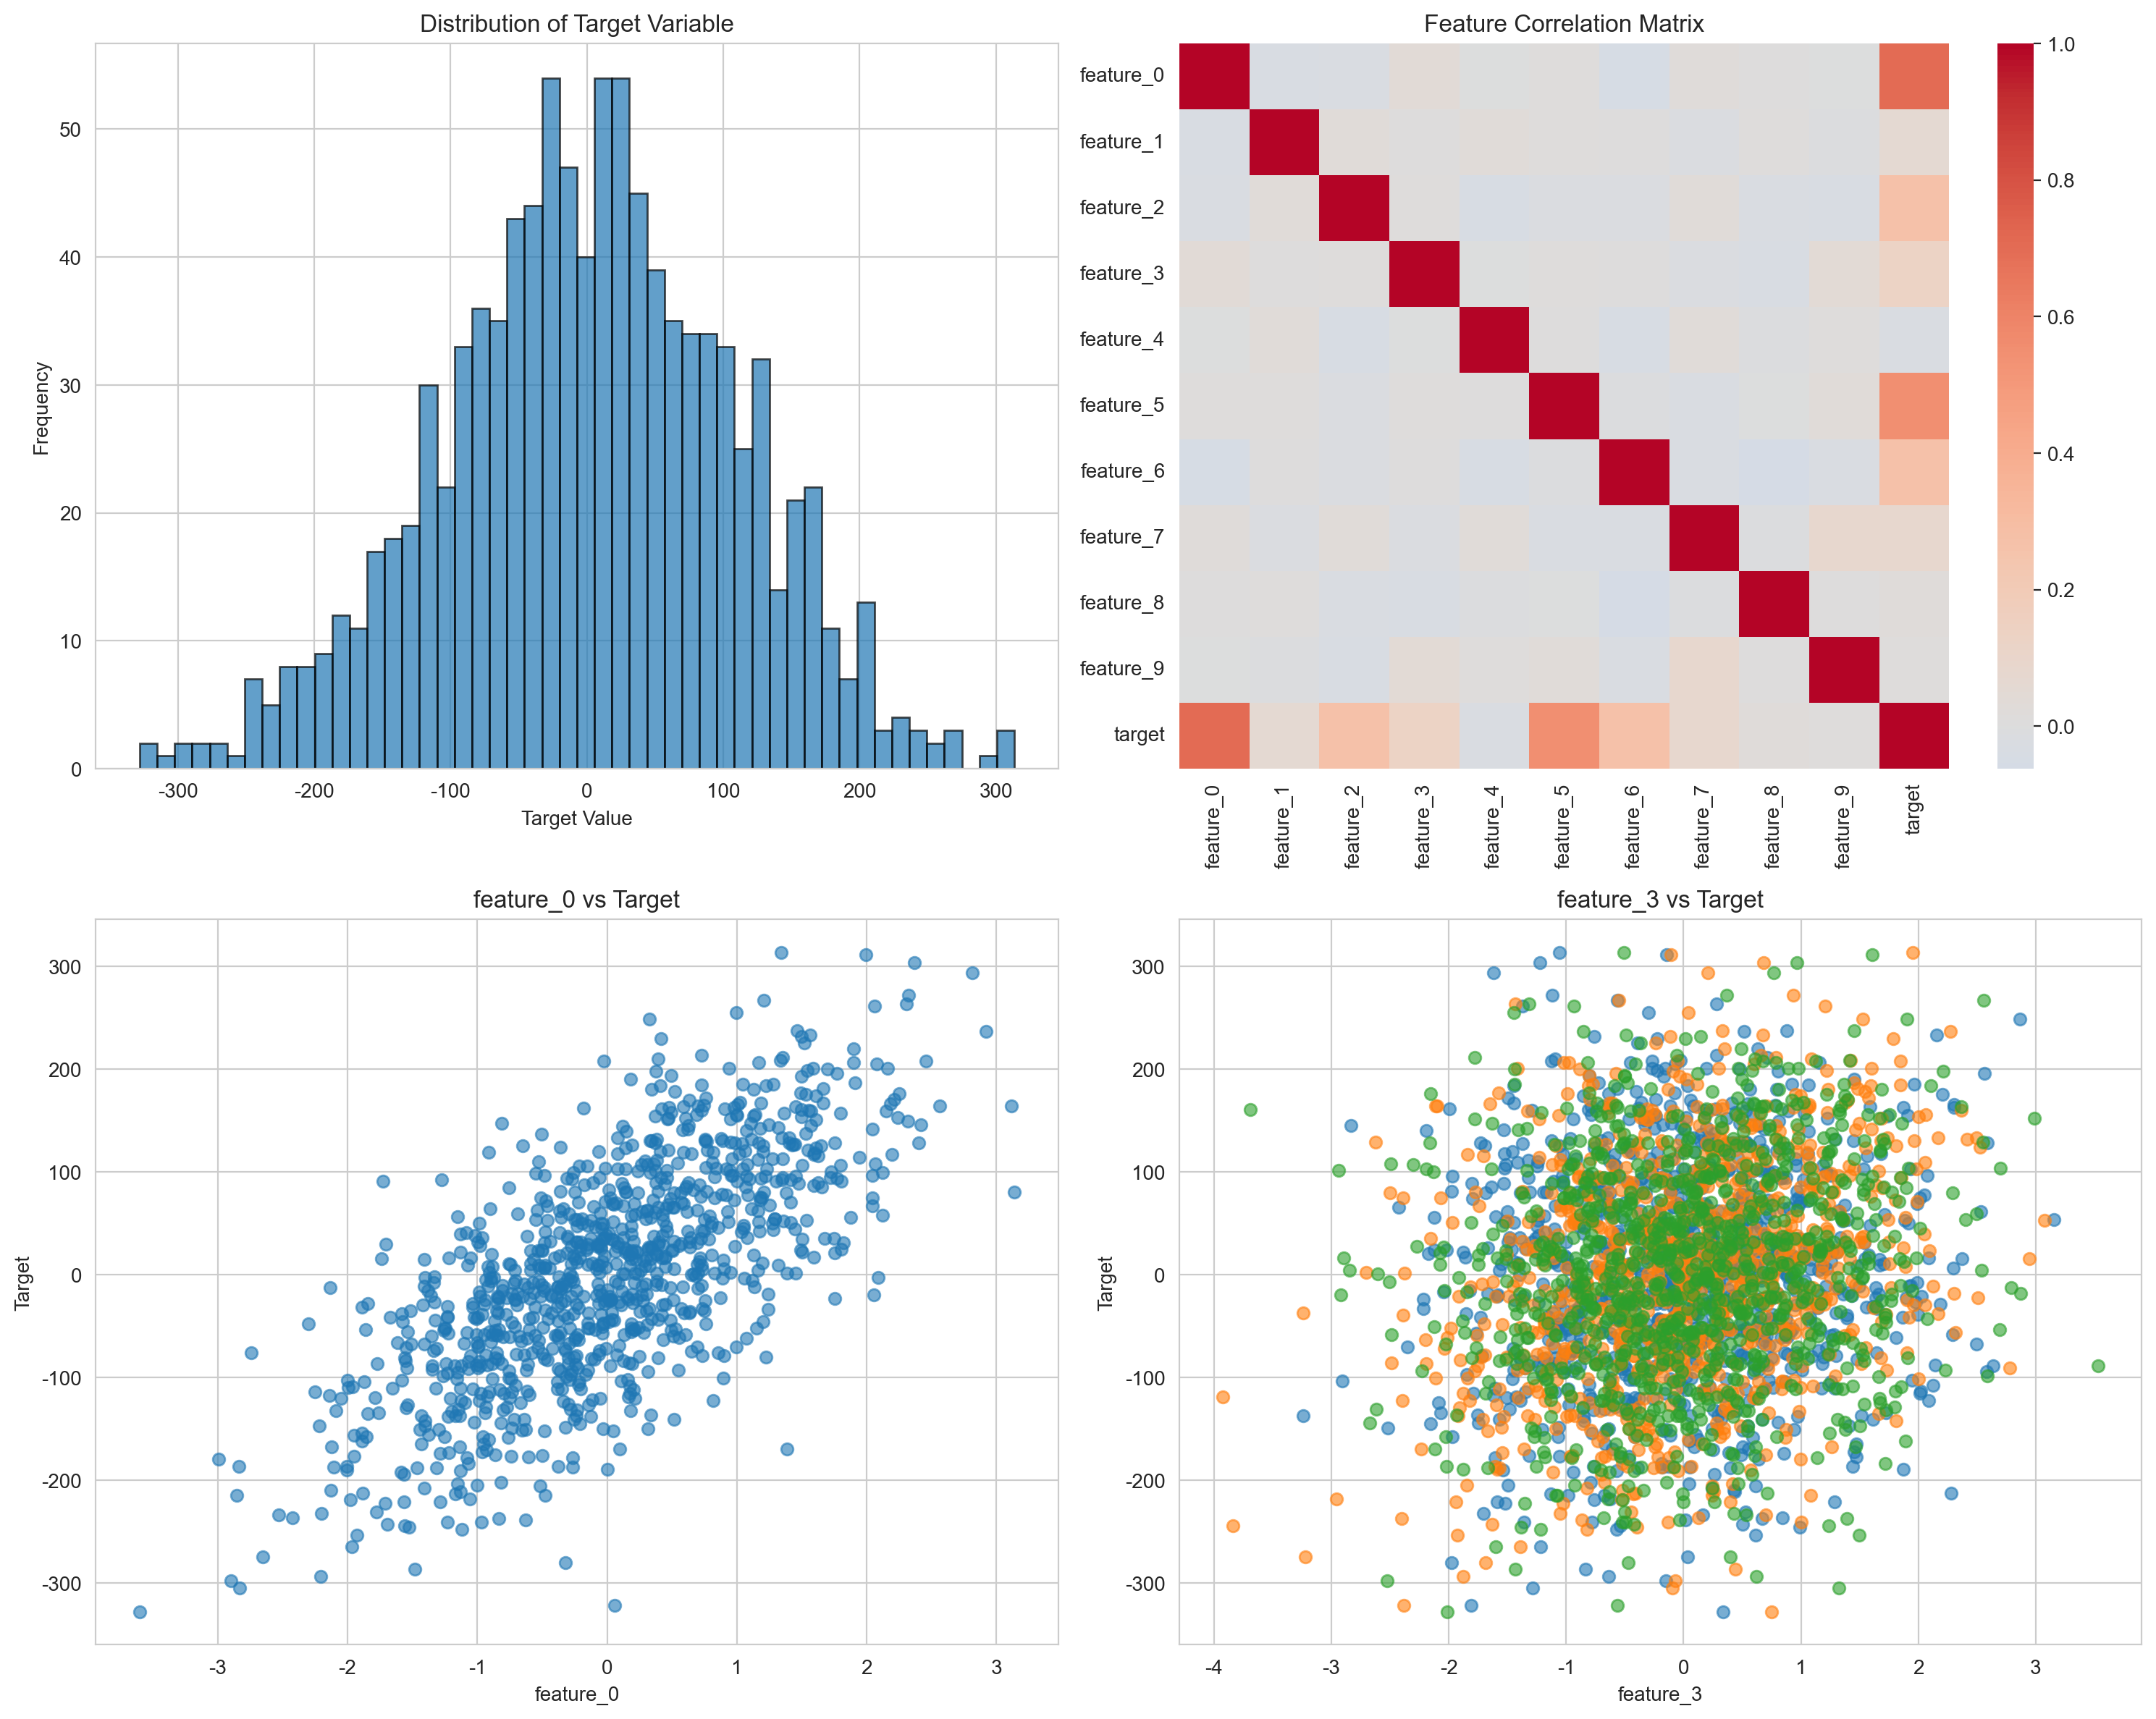

Statistical Summary of Features:
         feature_0    feature_1    feature_2    feature_3    feature_4  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.005495    -0.022542     0.010788     0.031292     0.038105   
std       1.030962     0.983366     1.005433     1.016046     0.945284   
min      -3.601085    -3.241267    -3.922400    -3.688365    -3.176704   
25%      -0.713176    -0.702626    -0.616527    -0.631506    -0.559290   
50%      -0.013284    -0.015036     0.014006     0.007605     0.019097   
75%       0.696602     0.613766     0.679698     0.685621     0.687027   
max       3.137749     3.152057     3.076860     3.529055     3.852731   

         feature_5    feature_6    feature_7    feature_8    feature_9  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.013622    -0.002689    -0.043075    -0.029252    -0.023104   
std       1.012645     1.031230     0.983406     1.037024     0.986846   
min 

In [4]:
# Exploratory Data Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of target variable
axes[0,0].hist(df['target'], bins=50, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Distribution of Target Variable')
axes[0,0].set_xlabel('Target Value')
axes[0,0].set_ylabel('Frequency')

# Feature correlation heatmap
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, ax=axes[0,1])
axes[0,1].set_title('Feature Correlation Matrix')

# Scatter plots for top 4 features against target
for i, feature in enumerate(feature_names[:4]):
    row, col = (1, i//2) if i >= 2 else (1, i)
    axes[row, col].scatter(df[feature], df['target'], alpha=0.6)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Target')
    axes[row, col].set_title(f'{feature} vs Target')

plt.tight_layout()
plt.show()

# Print statistical summary
print("Statistical Summary of Features:")
print(df.describe())

In [5]:
# Train XGBoost model
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Training R² Score: {train_score:.4f}")
print(f"Test R² Score: {test_score:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

Model Performance Metrics:
Training R² Score: 0.9991
Test R² Score: 0.9473
Test MSE: 656.8237
Test RMSE: 25.6286
Test MAE: 19.1868
Test R²: 0.9473


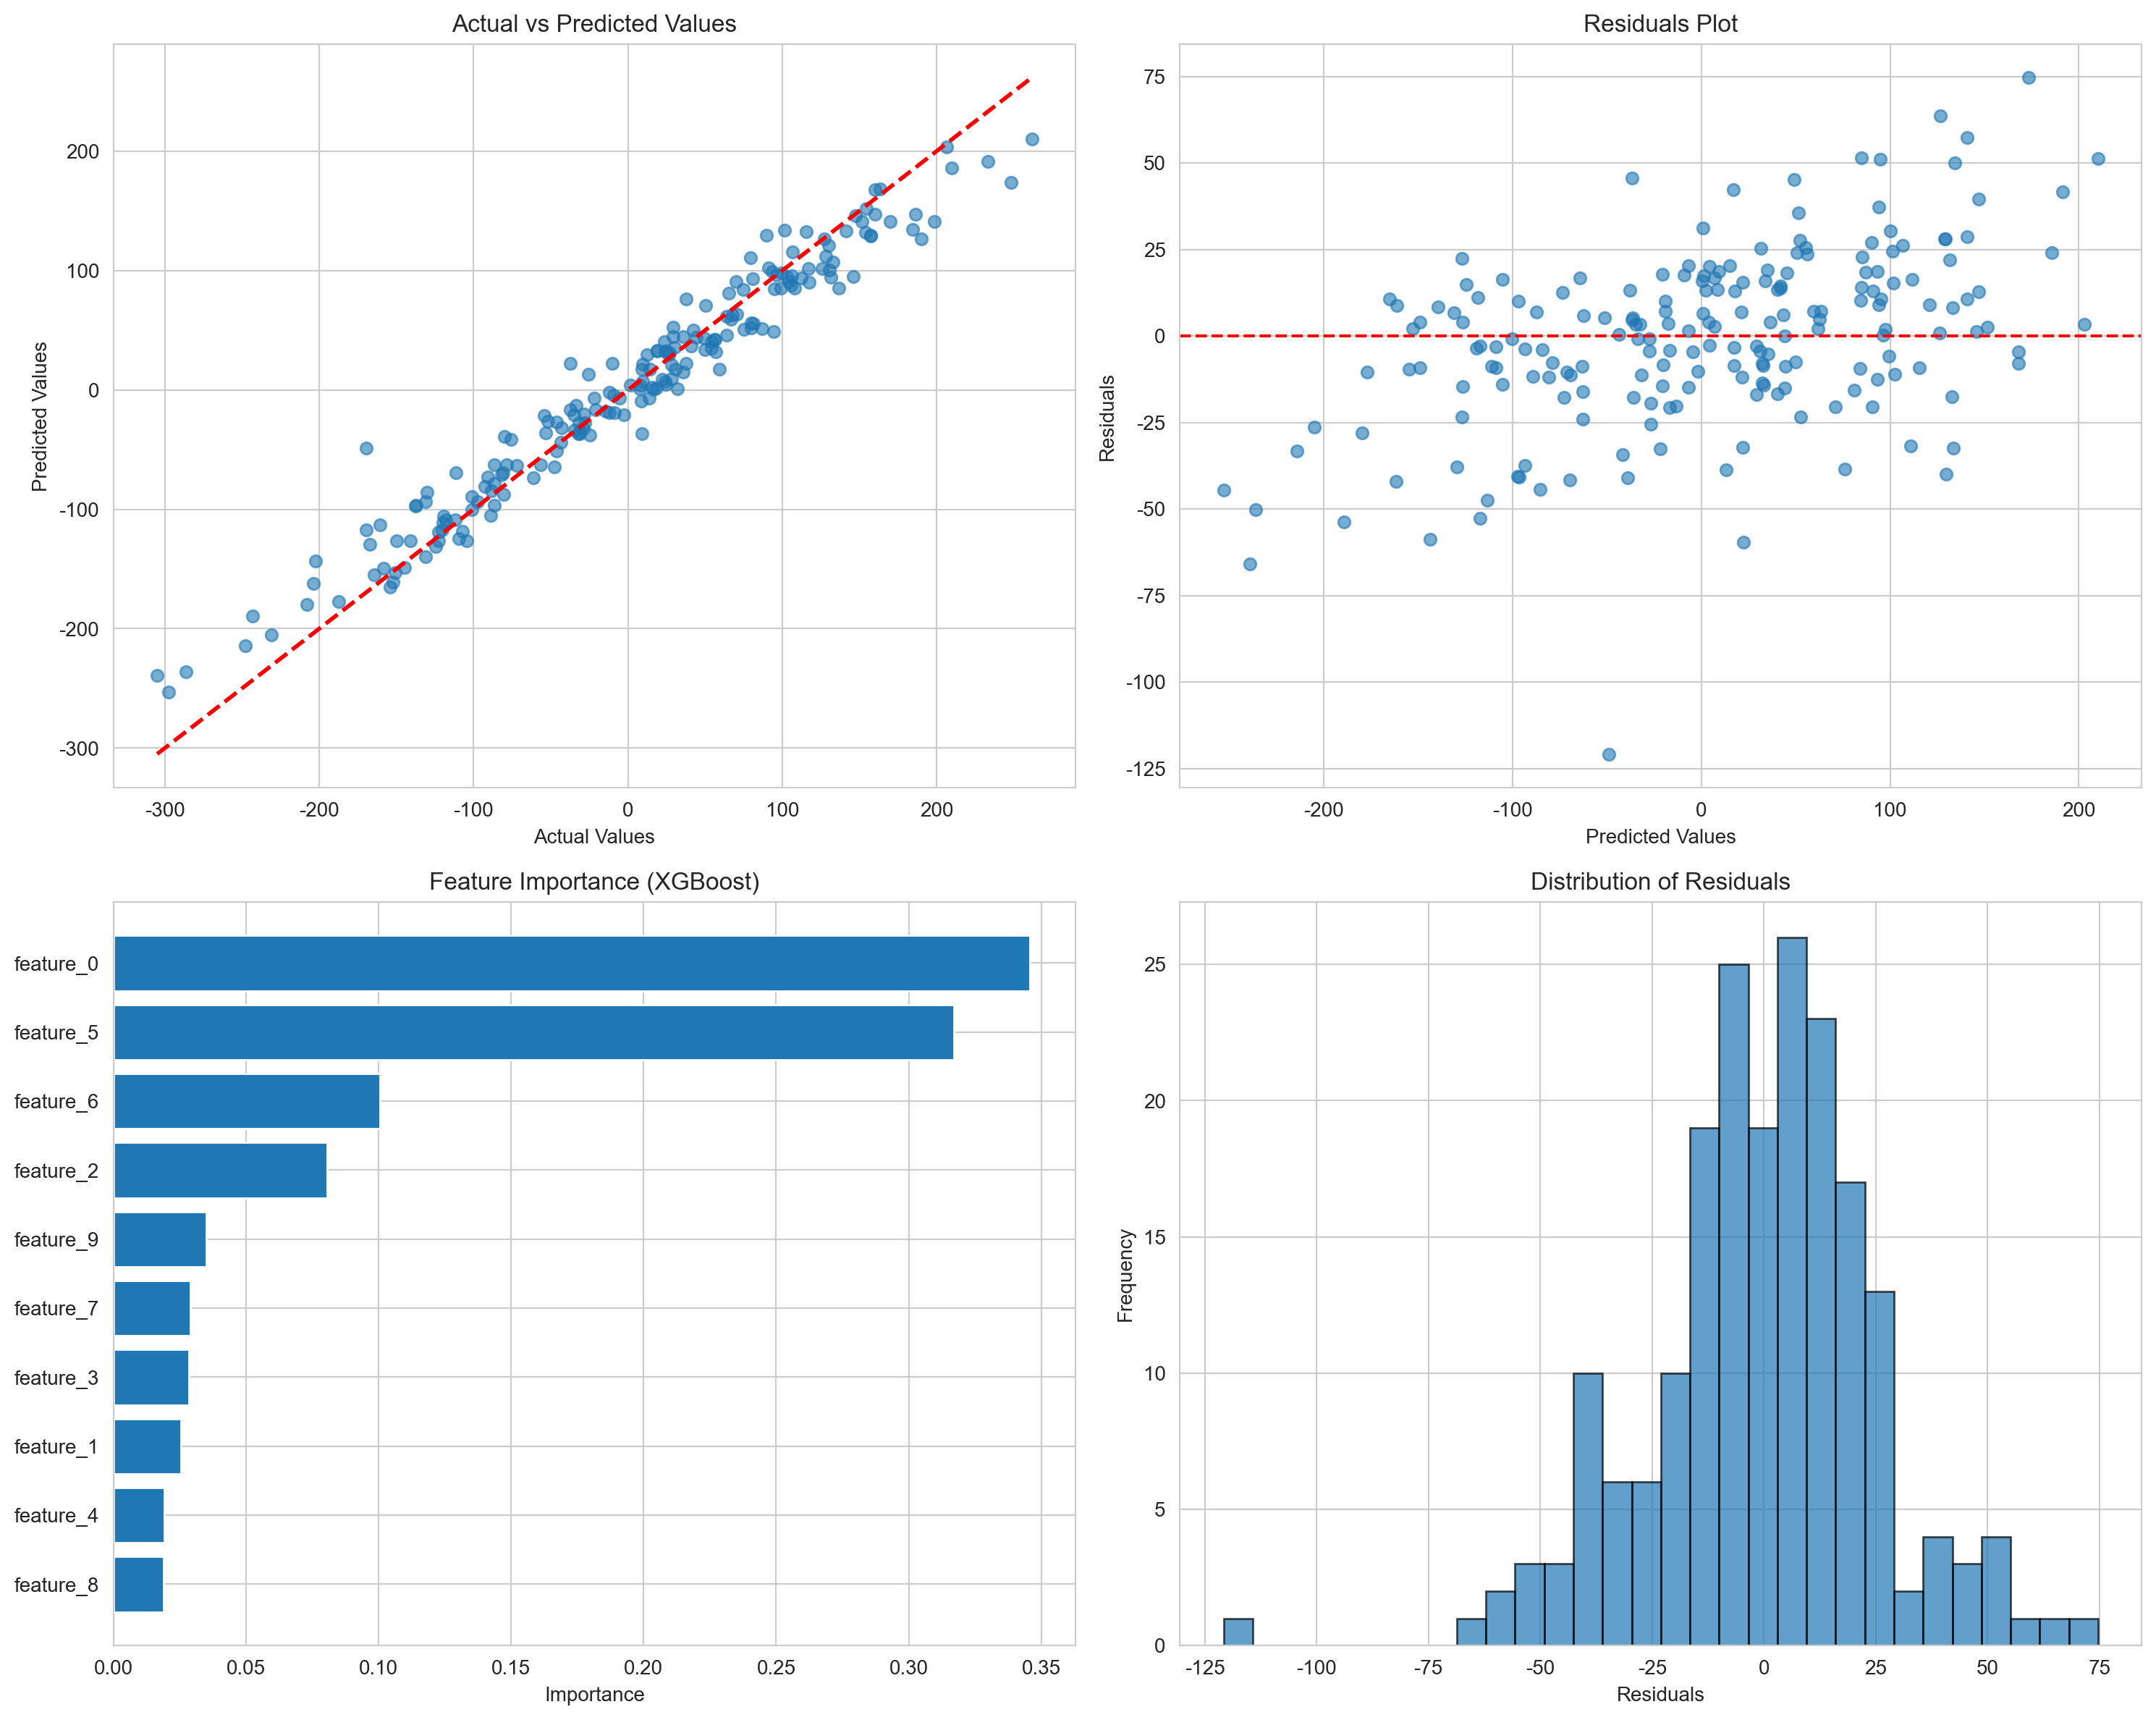

In [6]:
# Visualization of results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Actual vs Predicted values
axes[0,0].scatter(y_test, y_pred, alpha=0.6)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Values')
axes[0,0].set_ylabel('Predicted Values')
axes[0,0].set_title('Actual vs Predicted Values')

# Residuals plot
residuals = y_test - y_pred
axes[0,1].scatter(y_pred, residuals, alpha=0.6)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predicted Values')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residuals Plot')

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

axes[1,0].barh(range(len(feature_importance)), feature_importance['importance'])
axes[1,0].set_yticks(range(len(feature_importance)))
axes[1,0].set_yticklabels(feature_importance['feature'])
axes[1,0].set_xlabel('Importance')
axes[1,0].set_title('Feature Importance (XGBoost)')

# Distribution of residuals
axes[1,1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1,1].set_xlabel('Residuals')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()

In [7]:
# Model interpretation and insights
print("Feature Importance Ranking:")
feature_importance_sorted = feature_importance.sort_values('importance', ascending=False)
print(feature_importance_sorted.round(4))

print(f"\nModel Parameters:")
print(f"Number of estimators: {model.n_estimators}")
print(f"Max depth: {model.max_depth}")
print(f"Learning rate: {model.learning_rate}")

# Calculate and display prediction statistics
print(f"\nPrediction Statistics:")
print(f"Mean of predictions: {y_pred.mean():.2f}")
print(f"Std of predictions: {y_pred.std():.2f}")
print(f"Mean of actuals: {y_test.mean():.2f}")
print(f"Std of actuals: {y_test.std():.2f}")

# Display XGBoost specific information
print(f"\nNumber of features used in model: {model.n_features_in_}")

Feature Importance Ranking:
     feature  importance
0  feature_0      0.3456
5  feature_5      0.3170
6  feature_6      0.1007
2  feature_2      0.0807
9  feature_9      0.0350
7  feature_7      0.0289
3  feature_3      0.0285
1  feature_1      0.0254
4  feature_4      0.0192
8  feature_8      0.0190

Model Parameters:
Number of estimators: 100
Max depth: 6
Learning rate: 0.1

Prediction Statistics:
Mean of predictions: 2.24
Std of predictions: 97.24
Mean of actuals: 1.75
Std of actuals: 111.87

Number of features used in model: 10
